In [334]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [335]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/16h5/s_yaw_16h5_5m_720_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [336]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [337]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,5.178055
1,0.358258,-13.029610
2,0.358833,5.033034
3,0.706223,4.877658
4,1.029648,4.768752
...,...,...
1000,128.095838,-67.190514
1001,128.204867,-9.063948
1002,128.324646,1.120767
1003,129.960559,61.133503


In [338]:
# remove some rows due to a video error
df = df[~df.relative_time.between(56, 60, inclusive=True)]
# remove some of the spikes caused by fp detections
df = df.drop(df[df.yaw < -5].index).reset_index()

/tmp/ipykernel_7858/28374986.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df = df[~df.relative_time.between(56, 60, inclusive=True)]


<AxesSubplot:xlabel='relative_time'>

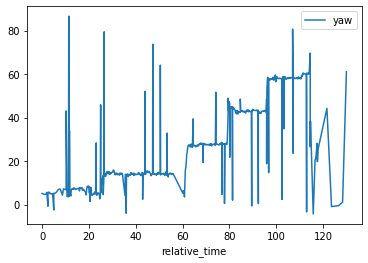

In [339]:
# initial graph
df.plot(x='relative_time', y=target)

In [340]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [341]:
# the amount of data points we are left with
len(x[peaks])

169

In [342]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

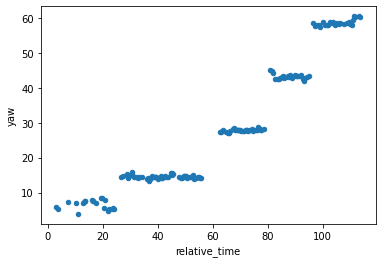

In [343]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [344]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.qcut(df_filtered_by_targets[target], len(input_vals), labels=input_vals, duplicates='drop')

In [345]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [346]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [347]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [348]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,index,relative_time,yaw,true_yaw,error
9,10,2.985548,5.832843,0,-5.832843
11,12,3.569644,5.200209,0,-5.200209
20,21,7.421104,7.233086,0,-7.233086
26,28,10.070429,6.995954,0,-6.995954
30,32,10.842780,3.862238,0,-3.862238
47,49,12.622459,7.092477,0,-7.092477
52,54,13.125982,7.437178,0,-7.437178
55,57,13.433311,7.470481,0,-7.470481
58,60,13.630093,7.716335,0,-7.716335
69,81,16.165098,7.755141,0,-7.755141


In [349]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(2)

,index,relative_time,yaw,true_yaw,error
129,154,23.626385,5.479337,0,-5.479337
132,158,24.127587,5.374264,0,-5.374264
397,461,55.429051,14.178455,15,0.821545
399,463,55.632061,14.173034,15,0.826966
527,639,74.862173,27.855783,30,2.144217
552,664,77.450492,27.958982,30,2.041018
690,808,94.296703,43.085263,45,1.914737
695,813,95.029213,43.336132,45,1.663868
848,971,113.202223,60.508111,60,-0.508111
853,976,113.748905,60.454096,60,-0.454096


In [350]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,22.0,-6.626210,1.322668,-8.482958,-7.672485,-7.086909,-5.415604,-3.862238
15,34.0,0.515186,0.186045,0.164804,0.405461,0.547418,0.624483,0.826966
30,24.0,2.288315,0.247059,1.997239,2.142257,2.214506,2.333140,2.920634
45,23.0,1.975242,0.379361,1.455486,1.682354,1.963318,2.230903,2.991976
60,28.0,1.313206,0.844919,-0.508111,1.131807,1.539871,1.905468,2.465156


In [351]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

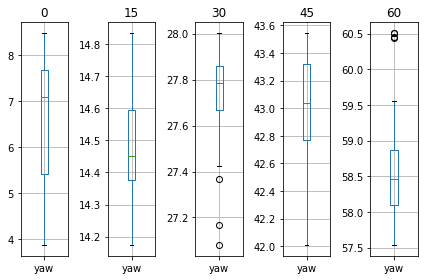

In [352]:
box_plotter(target)

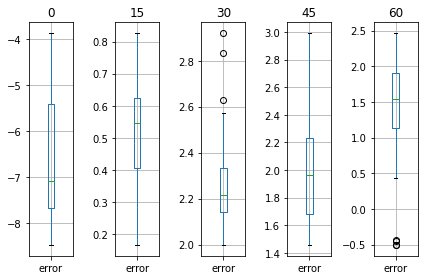

In [353]:
box_plotter('error')